## ML Model Gold Standard

### Datasource
    1. https://www.kaggle.com/uciml/indian-liver-patient-records

### Objective
    1. To classify a person into patient or non-patient using collected data.

### Target
    1. Difference between Train - Test Accuracy < 5%
    2. Test Accuracy >= 90%
    3. Recall >= 90%

### Observations:
    1. Aforementioned target was not achieveable with the given dataset. Combinations of following conditions were tried:
        a. MinMax vs Standard Scalers
        b. Outlier treatment (with & without outlier removal)
        c. Train-Test Split Ratios [80-20, 85-15, 90-10]
        d. Eval metrics for hypertuning [f1, Accuracy, auc]
        e. Feature engineering.
        f. Best approach is to build the MLM model for Male and Female genders independently along with some level of feature engineering.
        g. Model generalizeability is quite low.

### Pre-Processing

#### Libraries

In [1]:
import sys
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [12, 10]

import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# --------------- End of sklearn libraries ---------------------

import optuna

import catboost as cb

import shap

#### Global Constants

In [2]:
RND_STATE = 42  # random_state where used is assigned RND_STATE
TESTSIZE = 0.08  # test_size where used is assigned TESTSIZE

#### I/O Path & File Name

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Indian_Liver_Patient_10x1.csv"
PREFIX = r"\MLM_V3.0_LiverPatient_I1_"

# Specify number of features and targets

n_features = 10
n_target = 1

#### Dataframe Construction

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

df.drop(df[df.Gender == 'Female'].index, inplace=True) # Dropping Female & retaining only Male

dropcol = ['Gender', 'Direct_Bilirubin']
df = df.drop(columns=dropcol) # Dropping the column eventually.

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

#### Encoding

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
1,62,10.9,699,64,100,7.5,3.2,0.74,Patient
2,62,7.3,490,60,68,7.0,3.3,0.89,Patient
3,58,1.0,182,14,20,6.8,3.4,1.00,Patient
4,72,3.9,195,27,59,7.3,2.4,0.40,Patient
5,46,1.8,208,19,14,7.6,4.4,1.30,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
1,62,10.9,699,64,100,7.5,3.2,0.74,1
2,62,7.3,490,60,68,7.0,3.3,0.89,1
3,58,1.0,182,14,20,6.8,3.4,1.00,1
4,72,3.9,195,27,59,7.3,2.4,0.40,1
5,46,1.8,208,19,14,7.6,4.4,1.30,1


#### Imputing

In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Total_Bilirubin               0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    2
Dataset                       0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

Age                           0
Total_Bilirubin               0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64



#### Outlier Treatment

In [15]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [16]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['Age', 'Total_Bilirubin', 'Alkaline_Phosphotase', 'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

List of Targets: ['Dataset']

List of Categorical Variables: ['Dataset']

List of Categorical Targets ['Dataset']



#### Descriptive Stats

In [17]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [18]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                            |   count |    mean |     std |   min |    25% |   50% |   75% |   max |
|----------------------------|---------|---------|---------|-------|--------|-------|-------|-------|
| Age                        |     408 |  45.284 |  16.347 |     4 |     33 |    46 |    60 |    90 |
| Total_Bilirubin            |     408 |   2.748 |   4.048 |   0.4 |    0.8 |   1.1 |   2.6 |    23 |
| Alkaline_Phosphotase       |     408 | 262.336 | 145.186 |    75 | 176.75 |   210 |   290 |   950 |
| Alamine_Aminotransferase   |     408 |  61.956 |   76.66 |    10 |     25 |    37 |    60 |   622 |
| Aspartate_Aminotransferase |     408 |  86.676 | 127.133 |    11 |  27.75 |    44 | 86.25 |   950 |
| Total_Protiens             |     408 |   6.463 |   1.017 |   3.6 |    5.8 |   6.5 |   7.1 |   9.6 |
| Albumin                    |     408 |    3.13 |   0.768 |   0.9 |    2.6 |   3.1 |   3.7 |     5 |
| Albumin_and_Globulin_Ratio |     408 |   0.941 |   0.296 |   0.3 |    0.7 | 0.96

#### Train-Test Split

In [19]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


#### Random Over Sampling

In [20]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 1    268
0    107
Name: Dataset, dtype: int64
After Upsampling: 0    268
1    268
Name: Dataset, dtype: int64


#### Random Under Sampling

In [21]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [22]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [23]:
X_train.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,65,0.7,265,30,28,5.2,1.8,0.52
1,26,1.9,180,22,19,8.2,4.1,1.00
2,21,18.5,380,390,500,8.2,4.1,1.00
3,21,0.7,135,27,26,6.4,3.3,1.00
4,33,2.1,480,38,22,6.5,3.0,0.80


In [24]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [25]:
X_test.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
546,45,20.2,188,47,32,5.4,2.3,0.7
58,51,0.8,367,42,18,5.2,2.0,0.6
438,65,0.8,162,30,90,3.8,1.4,0.5
468,66,1.0,190,30,54,5.3,2.1,0.6
187,60,2.1,191,114,247,4.0,1.6,0.6


In [26]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [27]:
y_train.head()

,Dataset
0,0
1,0
2,1
3,0
4,1


In [28]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [29]:
y_test.head()

,Dataset
546,1
58,1
438,1
468,1
187,1


#### Feature Scaling

In [30]:
# Scaling

# scaler = StandardScaler()
scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [31]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [32]:
X_train_sc_df.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.709302,0.013274,0.217143,0.032680,0.018104,0.266667,0.225,0.1375
1,0.255814,0.066372,0.120000,0.019608,0.008520,0.766667,0.800,0.4375
2,0.197674,0.800885,0.348571,0.620915,0.520767,0.766667,0.800,0.4375
3,0.197674,0.013274,0.068571,0.027778,0.015974,0.466667,0.600,0.4375
4,0.337209,0.075221,0.462857,0.045752,0.011715,0.483333,0.525,0.3125


In [33]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [34]:
X_test_sc_df.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.476744,0.876106,0.129143,0.060458,0.022364,0.300000,0.350,0.2500
1,0.546512,0.017699,0.333714,0.052288,0.007455,0.266667,0.275,0.1875
2,0.709302,0.017699,0.099429,0.032680,0.084132,0.033333,0.125,0.1250
3,0.720930,0.026549,0.131429,0.032680,0.045793,0.283333,0.300,0.1875
4,0.651163,0.075221,0.132571,0.169935,0.251331,0.066667,0.175,0.1875


### Machine Learning Models

#### Tuning Logistic Regression

In [35]:
def LR_Opt(trial):
    penalty = trial.suggest_categorical("penalty", ['l2'])
    solver = trial.suggest_categorical("solver", ['newton-cg', 'lbfgs', 'liblinear'])
    c_values = trial.suggest_int('C', 1, 1000)
    Log_Reg = LogisticRegression(penalty=penalty, solver=solver, C=c_values, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction
    y_pred = Log_Reg.predict(X_test_sc)

    Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
    Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_LR = CM[1, 1]
    TN_LR = CM[0, 0]
    FP_LR = CM[0, 1]
    FN_LR = CM[1, 0]
    Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
    Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
    f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
    Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
    AUC_LR = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_LR, Precision_LR, Recall_LR

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (LR_Opt, n_trials=100)

[I 2021-08-07 20:15:16,103] A new study created in memory with name: no-name-a4b246b2-fa24-4c68-b33e-4335c64635b3
[I 2021-08-07 20:15:16,129] Trial 0 finished with values: [0.76, 0.94, 0.71] and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 573}. 
[I 2021-08-07 20:15:16,142] Trial 1 finished with values: [0.76, 0.94, 0.71] and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 619}. 
[I 2021-08-07 20:15:16,151] Trial 2 finished with values: [0.76, 0.94, 0.71] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 287}. 
[I 2021-08-07 20:15:16,159] Trial 3 finished with values: [0.76, 0.94, 0.71] and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'C': 18}. 
[I 2021-08-07 20:15:16,181] Trial 4 finished with values: [0.76, 0.94, 0.71] and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 326}. 
[I 2021-08-07 20:15:16,200] Trial 5 finished with values: [0.76, 0.94, 0.71] and parameters: {'penalty': 'l2', 'solver': 'newton-cg', 'C': 500}. 
[I 2021-08-07 2

In [36]:
LR_Best = study.best_trials[0]
LR_Best = LR_Best.params

In [37]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [38]:
LR_Best

{'penalty': 'l2', 'solver': 'newton-cg', 'C': 573}

#### Logistic Regression

In [39]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [40]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [41]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [42]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.53,0.89,0.67,9.00
1,0.94,0.71,0.81,24.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.74,0.80,0.74,33.00
weighted avg,0.83,0.76,0.77,33.00


#### Tuning Ada Boost

In [43]:
def ABC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 600) # Number of Trees in the Forest
    learning_rate = trial.suggest_float('learning_rate', 0.05, 1)
    ABC = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction

    y_pred = ABC.predict(X_test_sc)

    Train_Acc_ABC = round(ABC.score(X_train_sc, y_train),2)
    Test_Acc_ABC = round(ABC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_ABC = CM[1, 1]
    TN_ABC = CM[0, 0]
    FP_ABC = CM[0, 1]
    FN_ABC = CM[1, 0]
    Precision_ABC = round(TP_ABC/(TP_ABC + FP_ABC), 2)
    Recall_ABC = round(TP_ABC/(TP_ABC+FN_ABC), 2)
    f1_ABC = round((2*Precision_ABC*Recall_ABC)/(Precision_ABC+Recall_ABC), 2)
    Specificity_ABC = round(TN_ABC/(TN_ABC+FP_ABC), 2)
    AUC_ABC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_ABC, Precision_ABC, Recall_ABC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize(ABC_Opt, n_trials=100)

[I 2021-08-07 20:15:19,790] A new study created in memory with name: no-name-ba862b23-c637-4dd2-852d-527c3e3382c5
[I 2021-08-07 20:15:20,755] Trial 0 finished with values: [0.76, 0.83, 0.83] and parameters: {'n_estimators': 530, 'learning_rate': 0.27432455650969123}. 
[I 2021-08-07 20:15:21,821] Trial 1 finished with values: [0.73, 0.8, 0.83] and parameters: {'n_estimators': 550, 'learning_rate': 0.8661020617661093}. 
[I 2021-08-07 20:15:22,084] Trial 2 finished with values: [0.73, 0.83, 0.79] and parameters: {'n_estimators': 140, 'learning_rate': 0.36207154178460466}. 
[I 2021-08-07 20:15:22,670] Trial 3 finished with values: [0.76, 0.86, 0.79] and parameters: {'n_estimators': 323, 'learning_rate': 0.13586478364163634}. 
[I 2021-08-07 20:15:23,432] Trial 4 finished with values: [0.76, 0.83, 0.83] and parameters: {'n_estimators': 421, 'learning_rate': 0.1898067574418586}. 
[I 2021-08-07 20:15:23,945] Trial 5 finished with values: [0.76, 0.83, 0.83] and parameters: {'n_estimators': 283,

In [44]:
ABC_Best = study.best_trials[0]
ABC_Best = ABC_Best.params

In [45]:
print("------ Ada Boost Best Parameters ------")

------ Ada Boost Best Parameters ------


In [46]:
ABC_Best

{'n_estimators': 530, 'learning_rate': 0.27432455650969123}

In [47]:
#### Ada Boost

In [48]:
# Model: Ada Boost Classifier (ABC) 

ABC = AdaBoostClassifier(**ABC_Best, random_state=RND_STATE)
ABC.fit(X_train_sc, y_train)

# Prediction

y_pred = ABC.predict(X_test_sc)

Train_Acc_ABC = round(ABC.score(X_train_sc, y_train),2)
Test_Acc_ABC = round(ABC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ABC = CM[1, 1]
TN_ABC = CM[0, 0]
FP_ABC = CM[0, 1]
FN_ABC = CM[1, 0]

Precision_ABC = round(TP_ABC/(TP_ABC + FP_ABC), 2)
Recall_ABC = round(TP_ABC/(TP_ABC+FN_ABC), 2)
f1_ABC = round((2*Precision_ABC*Recall_ABC)/(Precision_ABC+Recall_ABC), 2)
Specificity_ABC = round(TN_ABC/(TN_ABC+FP_ABC), 2)
AUC_ABC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ABC, tpr_ABC, threshold_ABC = roc_curve(y_test, y_pred, pos_label=1)

In [49]:
ABC_Rep = classification_report(y_test, y_pred, output_dict=True)
ABC_Rep_df = pd.DataFrame(ABC_Rep).transpose()

In [50]:
print("-------- Ada Boost Summary -------- ")

-------- Ada Boost Summary -------- 


In [51]:
ABC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.56,0.56,0.56,9.00
1,0.83,0.83,0.83,24.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.69,0.69,0.69,33.00
weighted avg,0.76,0.76,0.76,33.00


#### Tuning Random Forest

In [52]:
def RFC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600, 50) # Number of Trees in the Forest
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 3, 7, 1) # max number of Levels in each decision tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5, 3)
    RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, criterion=criterion,
                                max_depth=max_depth, min_samples_split=min_samples_split, random_state=RND_STATE).fit(X_train_sc, y_train)
    # Prediction

    y_pred = RFC.predict(X_test_sc)

    Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
    Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_RFC = CM[1, 1]
    TN_RFC = CM[0, 0]
    FP_RFC = CM[0, 1]
    FN_RFC = CM[1, 0]
    Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
    Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
    f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
    Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
    AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_RFC, Precision_RFC, Recall_RFC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize(RFC_Opt, n_trials=100)

[I 2021-08-07 20:16:18,906] A new study created in memory with name: no-name-99f34c59-c4d9-481c-889f-a5e85f4062c3
[I 2021-08-07 20:16:19,425] Trial 0 finished with values: [0.79, 0.95, 0.75] and parameters: {'n_estimators': 300, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}. 
[I 2021-08-07 20:16:19,663] Trial 1 finished with values: [0.79, 0.95, 0.75] and parameters: {'n_estimators': 150, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}. 
[I 2021-08-07 20:16:20,429] Trial 2 finished with values: [0.76, 0.94, 0.71] and parameters: {'n_estimators': 450, 'max_features': 'auto', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5}. 
[I 2021-08-07 20:16:21,067] Trial 3 finished with values: [0.76, 0.94, 0.71] and parameters: {'n_estimators': 400, 'max_features': 'sqrt', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5}. 
[I 2021-08-07 20:16:21,245] Trial 4 finished with values: [0.76, 0.94

In [53]:
RFC_Best = study.best_trials[0]
RFC_Best = RFC_Best.params

In [54]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [55]:
RFC_Best

{'n_estimators': 300,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'max_depth': 6,
 'min_samples_split': 5}

#### Random Forest

In [56]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [57]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [58]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [59]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.67,0.89,0.76,9.00
1,0.95,0.83,0.89,24.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.81,0.86,0.83,33.00
weighted avg,0.87,0.85,0.85,33.00


#### Tuning Extra Trees

In [60]:
def ETC_Opt(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 600, 50) # Number of Trees in the Forest
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt'])
    criterion = trial.suggest_categorical('criterion', ['entropy', 'gini'])
    max_depth = trial.suggest_int('max_depth', 3, 7, 1) # max number of Levels in each decision tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 5, 3)
    ETC = ExtraTreesClassifier(n_estimators=n_estimators, max_features=max_features, criterion=criterion,
                                max_depth=max_depth, min_samples_split=min_samples_split, random_state=RND_STATE).fit(X_train_sc, y_train)
    # Prediction

    y_pred = ETC.predict(X_test_sc)

    Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
    Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_ETC = CM[1, 1]
    TN_ETC = CM[0, 0]
    FP_ETC = CM[0, 1]
    FN_ETC = CM[1, 0]
    Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
    Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
    f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
    Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
    AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_ETC, Precision_ETC, Recall_ETC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (ETC_Opt, n_trials=100)

[I 2021-08-07 20:17:10,696] A new study created in memory with name: no-name-b1471f3e-e7a5-4d89-bbc0-1eab8af09162
[I 2021-08-07 20:17:11,293] Trial 0 finished with values: [0.73, 0.94, 0.67] and parameters: {'n_estimators': 450, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 5}. 
[I 2021-08-07 20:17:12,103] Trial 1 finished with values: [0.73, 0.94, 0.67] and parameters: {'n_estimators': 600, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2}. 
[I 2021-08-07 20:17:12,807] Trial 2 finished with values: [0.73, 0.94, 0.67] and parameters: {'n_estimators': 550, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}. 
[I 2021-08-07 20:17:13,219] Trial 3 finished with values: [0.73, 0.94, 0.67] and parameters: {'n_estimators': 300, 'max_features': 'auto', 'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 2}. 
[I 2021-08-07 20:17:13,414] Trial 4 finished with values: [0.73, 0.94, 0.67] a

In [61]:
ETC_Best = study.best_trials[0]
ETC_Best = ETC_Best.params

In [62]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [63]:
ETC_Best

{'n_estimators': 550,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 5}

#### Extra Trees

In [64]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [65]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [66]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [67]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.67,0.89,0.76,9.00
1,0.95,0.83,0.89,24.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.81,0.86,0.83,33.00
weighted avg,0.87,0.85,0.85,33.00


#### Tuning Kernel SVM

In [68]:
def KSV_Opt(trial):
    c_values = trial.suggest_int('C', 1, 100, 10)
    kernel = trial.suggest_categorical('kernel', ['poly', 'rbf'])
    gamma = trial.suggest_float('gamma', 0.001, 0.01)
    KSV = svm.SVC (kernel=kernel, C=c_values, gamma=gamma, random_state=RND_STATE).fit(X_train_sc, y_train)
    
    # Prediction

    y_pred = KSV.predict(X_test_sc)

    Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
    Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_KSV = CM[1, 1]
    TN_KSV = CM[0, 0]
    FP_KSV = CM[0, 1]
    FN_KSV = CM[1, 0]
    Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
    Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
    f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
    Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
    AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_KSV, Precision_KSV, Recall_KSV

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (KSV_Opt, n_trials=100)

[I 2021-08-07 20:18:00,983] A new study created in memory with name: no-name-b4e63d0c-2c30-455c-bc44-b5ff554fc920
[I 2021-08-07 20:18:01,013] Trial 0 finished with values: [0.64, 1.0, 0.5] and parameters: {'C': 91, 'kernel': 'poly', 'gamma': 0.009980800783118297}. 
[I 2021-08-07 20:18:01,037] Trial 1 finished with values: [0.64, 1.0, 0.5] and parameters: {'C': 71, 'kernel': 'poly', 'gamma': 0.0013915488357766764}. 
[I 2021-08-07 20:18:01,082] Trial 2 finished with values: [0.73, 0.94, 0.67] and parameters: {'C': 61, 'kernel': 'rbf', 'gamma': 0.006410697293051017}. 
[I 2021-08-07 20:18:01,107] Trial 3 finished with values: [0.64, 1.0, 0.5] and parameters: {'C': 31, 'kernel': 'poly', 'gamma': 0.00798007126706438}. 
[I 2021-08-07 20:18:01,157] Trial 4 finished with values: [0.67, 1.0, 0.54] and parameters: {'C': 21, 'kernel': 'rbf', 'gamma': 0.0015980238146014287}. 
[I 2021-08-07 20:18:01,201] Trial 5 finished with values: [0.7, 0.94, 0.62] and parameters: {'C': 31, 'kernel': 'rbf', 'gamm

In [69]:
KSV_Best = study.best_trials[0]
KSV_Best = KSV_Best.params

In [70]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [71]:
KSV_Best

{'C': 61, 'kernel': 'rbf', 'gamma': 0.006410697293051017}

#### Kernel SVM

In [72]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [73]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [74]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [75]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.50,0.89,0.64,9.00
1,0.94,0.67,0.78,24.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.72,0.78,0.71,33.00
weighted avg,0.82,0.73,0.74,33.00


#### Tuning CatBoost

In [76]:
def CBC_Opt(trial):
    train_dataset = cb. Pool (X_train_sc, y_train)
    test_dataset = cb.Pool(X_test_sc, y_test)
    
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    depth = trial.suggest_int('depth', 2, 7, 1) 
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 2, 5, 1)
    iterations = trial.suggest_int('iterations', 50, 600, 50)
    CBC = cb.CatBoostClassifier (loss_function='Logloss', random_state=RND_STATE, verbose=False,
    learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_leaf_reg, iterations=iterations).fit(X_train_sc, y_train)

# Prediction.
    y_pred = CBC.predict(X_test_sc)

    Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
    Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)
    CM = confusion_matrix(y_test, y_pred)
    TP_CBC = CM[1, 1]
    TN_CBC = CM[0, 0]
    FP_CBC = CM[0, 1]
    FN_CBC = CM[1, 0]
    Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
    Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
    f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
    Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
    AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)
    return Test_Acc_CBC, Precision_CBC, Recall_CBC

if __name__== "__main__":
    study = optuna.create_study(directions=["maximize", "maximize", "maximize"])
    study.optimize (CBC_Opt, n_trials=100)

[I 2021-08-07 20:18:05,635] A new study created in memory with name: no-name-7641f187-eee7-4769-8d9d-3d637cf7b5fe
[I 2021-08-07 20:18:06,515] Trial 0 finished with values: [0.73, 0.8, 0.83] and parameters: {'learning_rate': 0.05022828153088793, 'depth': 6, 'l2_leaf_reg': 3, 'iterations': 200}. 
[I 2021-08-07 20:18:07,348] Trial 1 finished with values: [0.76, 0.81, 0.88] and parameters: {'learning_rate': 0.06457631786899712, 'depth': 6, 'l2_leaf_reg': 5, 'iterations': 300}. 
[I 2021-08-07 20:18:07,973] Trial 2 finished with values: [0.7, 0.77, 0.83] and parameters: {'learning_rate': 0.07176393433783007, 'depth': 3, 'l2_leaf_reg': 3, 'iterations': 350}. 
[I 2021-08-07 20:18:08,683] Trial 3 finished with values: [0.76, 0.81, 0.88] and parameters: {'learning_rate': 0.0636700488944824, 'depth': 5, 'l2_leaf_reg': 3, 'iterations': 250}. 
[I 2021-08-07 20:18:09,299] Trial 4 finished with values: [0.7, 0.77, 0.83] and parameters: {'learning_rate': 0.09274615755070911, 'depth': 4, 'l2_leaf_reg':

In [77]:
CBC_Best = study.best_trials[0]
CBC_Best = CBC_Best.params

In [78]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [79]:
CBC_Best

{'learning_rate': 0.06363944804441335,
 'depth': 3,
 'l2_leaf_reg': 5,
 'iterations': 300}

#### CatBoost

In [80]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

0:	learn: 0.6805859	total: 3.64ms	remaining: 1.09s
1:	learn: 0.6644595	total: 7.68ms	remaining: 1.15s
2:	learn: 0.6513342	total: 10.9ms	remaining: 1.08s
3:	learn: 0.6418916	total: 13.3ms	remaining: 985ms
4:	learn: 0.6293928	total: 15.2ms	remaining: 896ms
5:	learn: 0.6202685	total: 16.9ms	remaining: 829ms
6:	learn: 0.6101216	total: 18.7ms	remaining: 783ms
7:	learn: 0.6030600	total: 20.1ms	remaining: 735ms
8:	learn: 0.5957245	total: 21.6ms	remaining: 699ms
9:	learn: 0.5885439	total: 23ms	remaining: 668ms
10:	learn: 0.5838500	total: 24.2ms	remaining: 635ms
11:	learn: 0.5791232	total: 25.4ms	remaining: 609ms
12:	learn: 0.5736860	total: 26.5ms	remaining: 586ms
13:	learn: 0.5695216	total: 27.6ms	remaining: 564ms
14:	learn: 0.5651749	total: 28.6ms	remaining: 544ms
15:	learn: 0.5616573	total: 29.7ms	remaining: 527ms
16:	learn: 0.5557589	total: 30.7ms	remaining: 511ms
17:	learn: 0.5503932	total: 31.8ms	remaining: 498ms
18:	learn: 0.5456399	total: 32.7ms	remaining: 484ms
19:	learn: 0.5426157	tot

In [81]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [82]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [83]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.56,0.56,0.56,9.00
1,0.83,0.83,0.83,24.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.69,0.69,0.69,33.00
weighted avg,0.76,0.76,0.76,33.00


#### Multi-Layer Perceptron

In [84]:
# Multi Layer Perceptron Classifier - MLP

MLP = MLPClassifier(hidden_layer_sizes=(300, 300), max_iter=300, alpha=1e-4, activation='relu', solver='adam', random_state=RND_STATE)
MLP.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = MLP.predict(X_test_sc).astype(int)

Train_Acc_MLP = round(MLP.score(X_train_sc, y_train),2)
Test_Acc_MLP = round(MLP.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_MLP = CM[1, 1]
TN_MLP = CM[0, 0]
FP_MLP = CM[0, 1]
FN_MLP = CM[1, 0]

Precision_MLP = round(TP_MLP/(TP_MLP + FP_MLP), 2)
Recall_MLP = round(TP_MLP/(TP_MLP + FN_MLP), 2)
f1_MLP = round((2*Precision_MLP*Recall_MLP)/(Precision_MLP+Recall_MLP), 2)
Specificity_MLP = round(TN_MLP/(TN_MLP+FP_MLP), 2)
AUC_MLP = round(roc_auc_score(y_test, y_pred), 2)

fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(y_test, y_pred, pos_label=1)

In [85]:
MLP_Rep = classification_report(y_test, y_pred, output_dict=True)
MLP_Rep_df = pd.DataFrame(MLP_Rep).transpose()

MLP_Best = {}

In [86]:
print("-------- Multi Layer Perceptron Classifier -------- ")

-------- Multi Layer Perceptron Classifier -------- 


In [87]:
MLP_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.50,0.56,0.53,9.00
1,0.83,0.79,0.81,24.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.66,0.67,0.67,33.00
weighted avg,0.74,0.73,0.73,33.00


#### Voting Classifier

In [88]:
# Voting Classifier

VOC = VotingClassifier(estimators=[('RFC', RFC), ('CBC', CBC)], voting='soft',
                       weights=[1,1], flatten_transform=True, n_jobs=-1)
VOC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = VOC.predict(X_test_sc).astype(int)

Train_Acc_VOC = round(VOC.score(X_train_sc, y_train),2)
Test_Acc_VOC = round(VOC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_VOC = CM[1, 1]
TN_VOC = CM[0, 0]
FP_VOC = CM[0, 1]
FN_VOC = CM[1, 0]

Precision_VOC = round(TP_VOC/(TP_VOC + FP_VOC), 2)
Recall_VOC = round(TP_VOC/(TP_VOC + FN_VOC), 2)
f1_VOC = round((2*Precision_VOC*Recall_VOC)/(Precision_VOC+Recall_VOC), 2)
Specificity_VOC = round(TN_VOC/(TN_VOC+FP_VOC), 2)
AUC_VOC = round(roc_auc_score(y_test, y_pred), 2)

fpr_VOC, tpr_VOC, threshold_VOC = roc_curve(y_test, y_pred, pos_label=1)

In [89]:
VOC_Rep = classification_report(y_test, y_pred, output_dict=True)
VOC_Rep_df = pd.DataFrame(VOC_Rep).transpose()

VOC_Best = {}

In [90]:
print("-------- Votiing Classifier -------- ")

-------- Votiing Classifier -------- 


In [91]:
VOC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.50,0.56,0.53,9.00
1,0.83,0.79,0.81,24.00
accuracy,0.73,0.73,0.73,0.73
macro avg,0.66,0.67,0.67,33.00
weighted avg,0.74,0.73,0.73,33.00


#### Stacking Classifier

In [92]:
# Stacking Classifier

STC = StackingClassifier(estimators=[('RFC', RFC), ('CBC', CBC)], final_estimator=MLP, passthrough=False, n_jobs=-1)
STC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = STC.predict(X_test_sc).astype(int)

Train_Acc_STC = round(STC.score(X_train_sc, y_train),2)
Test_Acc_STC = round(STC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_STC = CM[1, 1]
TN_STC = CM[0, 0]
FP_STC = CM[0, 1]
FN_STC = CM[1, 0]

Precision_STC = round(TP_STC/(TP_STC + FP_STC), 2)
Recall_STC = round(TP_STC/(TP_STC + FN_STC), 2)
f1_STC = round((2*Precision_STC*Recall_STC)/(Precision_STC+Recall_STC), 2)
Specificity_STC = round(TN_STC/(TN_STC+FP_STC), 2)
AUC_STC = round(roc_auc_score(y_test, y_pred), 2)

fpr_STC, tpr_STC, threshold_STC = roc_curve(y_test, y_pred, pos_label=1)

In [93]:
STC_Rep = classification_report(y_test, y_pred, output_dict=True)
STC_Rep_df = pd.DataFrame(STC_Rep).transpose()

STC_Best = {}

In [94]:
print("-------- Stacking Classifier -------- ")

-------- Stacking Classifier -------- 


In [95]:
STC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.60,0.33,0.43,9.00
1,0.79,0.92,0.85,24.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.69,0.62,0.64,33.00
weighted avg,0.74,0.76,0.73,33.00


### Results & Output

#### Output to Excel

In [96]:
modlst = ['Logistic_Regression', 'Ada_Boost', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'MLP', 'VOC', 'STC']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_ABC', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC',
          'Train_Acc_MLP', 'Train_Acc_VOC', 'Train_Acc_STC']
score2 = ['Test_Acc_LR', 'Test_Acc_ABC', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC',
          'Test_Acc_MLP', 'Test_Acc_VOC', 'Test_Acc_STC']
score3 = ['TP_LR', 'TP_ABC', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_MLP', 'TP_VOC', 'TP_STC']
score4 = ['TN_LR', 'TN_ABC', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_MLP', 'TN_VOC', 'TN_STC']
score5 = ['FP_LR', 'FP_ABC', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_MLP', 'FP_VOC', 'FP_STC']
score6 = ['FN_LR', 'FN_ABC',  'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_MLP', 'FN_VOC', 'FN_STC']
score7 = ['Precision_LR', 'Precision_ABC', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV',
          'Precision_CBC', 'Precision_MLP', 'Precision_VOC', 'Precision_STC']
score8 = ['Recall_LR', 'Recall_ABC',  'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_MLP', 'Recall_VOC', 'Recall_STC']
score9 = ['f1_LR', 'f1_ABC', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_MLP', 'f1_VOC', 'f1_STC']
score10 = ['Specificity_LR', 'Specificity_ABC', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV',
           'Specificity_CBC', 'Specificity_MLP', 'Specificity_VOC', 'Specificity_STC']
score11 = ['AUC_LR', 'AUC_ABC', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_MLP', 'AUC_VOC', 'AUC_STC']
score12 = ['LR_Best',  'ABC_Best',  'RFC_Best', 'ETC_Best', 'KSV_Best', 'CBC_Best', 'MLP_Best', 'VOC_Best', 'STC_Best']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []
bestparlst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    var12 = vars()[score12[i]]
    
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)
    bestparlst.append(var12)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst, bestparlst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC', 'Best_Params'])

#### Model Evaluation Summary

In [97]:
print("Evaluation Summary:")

Evaluation Summary:


In [98]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC,Best_Params
0,Logistic_Regression,0.72,0.76,17,8,1,7,0.94,0.71,0.81,0.89,0.8,"{'penalty': 'l2', 'solver': 'newton-cg', 'C': 573}"
1,Ada_Boost,0.92,0.76,20,5,4,4,0.83,0.83,0.83,0.56,0.69,"{'n_estimators': 530, 'learning_rate': 0.27432455650969123}"
2,Random_Forest,0.92,0.85,20,8,1,4,0.95,0.83,0.89,0.89,0.86,"{'n_estimators': 300, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}"
3,Extra_Trees,0.96,0.79,20,6,3,4,0.87,0.83,0.85,0.67,0.75,"{'n_estimators': 550, 'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5}"
4,Kernel_SVM,0.72,0.73,16,8,1,8,0.94,0.67,0.78,0.89,0.78,"{'C': 61, 'kernel': 'rbf', 'gamma': 0.006410697293051017}"
5,CatBoost,0.97,0.76,20,5,4,4,0.83,0.83,0.83,0.56,0.69,"{'learning_rate': 0.06363944804441335, 'depth': 3, 'l2_leaf_reg': 5, 'iterations': 300}"
6,MLP,0.91,0.73,19,5,4,5,0.83,0.79,0.81,0.56,0.67,{}
7,VOC,0.97,0.73,19,5,4,5,0.83,0.79,0.81,0.56,0.67,{}
8,STC,0.95,0.76,22,3,6,2,0.79,0.92,0.85,0.33,0.62,{}


In [99]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, ABC_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, MLP_Rep_df, VOC_Rep_df, STC_Rep_df],
                keys=['LR_Rep_df', 'ABC_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'MLP_Rep_df', 'VOC_Rep_df', 'STC_Rep_df'])).round(decimals=2)

In [100]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [101]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0             0.53       0.89    0.67      9.00   
           1             0.94       0.71    0.81      24.00  
           accuracy      0.76       0.76    0.76      0.76   
           macro avg     0.74       0.80    0.74      33.00  
           weighted avg  0.83       0.76    0.77      33.00  
ABC_Rep_df 0             0.56       0.56    0.56      9.00   
           1             0.83       0.83    0.83      24.00  
           accuracy      0.76       0.76    0.76      0.76   
           macro avg     0.69       0.69    0.69      33.00  
           weighted avg  0.76       0.76    0.76      33.00  
RFC_Rep_df 0             0.67       0.89    0.76      9.00   
           1             0.95       0.83    0.89      24.00  
           accuracy      0.85       0.85    0.85      0.85   
           macro avg     0.81       0.86    0.83      33.00  
           weighted avg  0.87       0.85    0.85      33.00  
ETC_Rep_df 0             0.67       0.89    0.76      9.00   
           1             0.95       0.83    0.89      24.00  
           accuracy      0.85       0.85    0.85      0.85   
           macro avg     0.81       0.86    0.83      33.00  
           weighted avg  0.87       0.85    0.85      33.00  
KSV_Rep_df 0             0.50       0.89    0.64      9.00   
           1             0.94       0.67    0.78      24.00  
           accuracy      0.73       0.73    0.73      0.73   
           macro avg     0.72       0.78    0.71      33.00  
           weighted avg  0.82       0.73    0.74      33.00  
CBC_Rep_df 0             0.56       0.56    0.56      9.00   
           1             0.83       0.83    0.83      24.00  
           accuracy      0.76       0.76    0.76      0.76   
           macro avg     0.69       0.69    0.69      33.00  
           weighted avg  0.76       0.76    0.76      33.00  
MLP_Rep_df 0             0.50       0.56    0.53      9.00   
           1             0.83       0.79    0.81      24.00  
           accuracy      0.73       0.73    0.73      0.73   
           macro avg     0.66       0.67    0.67      33.00  
           weighted avg  0.74       0.73    0.73      33.00  
VOC_Rep_df 0             0.50       0.56    0.53      9.00   
           1             0.83       0.79    0.81      24.00  
           accuracy      0.73       0.73    0.73      0.73   
           macro avg     0.66       0.67    0.67      33.00  
           weighted avg  0.74       0.73    0.73      33.00  
STC_Rep_df 0             0.60       0.33    0.43      9.00   
           1             0.79       0.92    0.85      24.00  
           accuracy      0.76       0.76    0.76      0.76   
           macro avg     0.69       0.62    0.64      33.00  
           weighted avg  0.74       0.76    0.73      33.00

#### ROC Curve

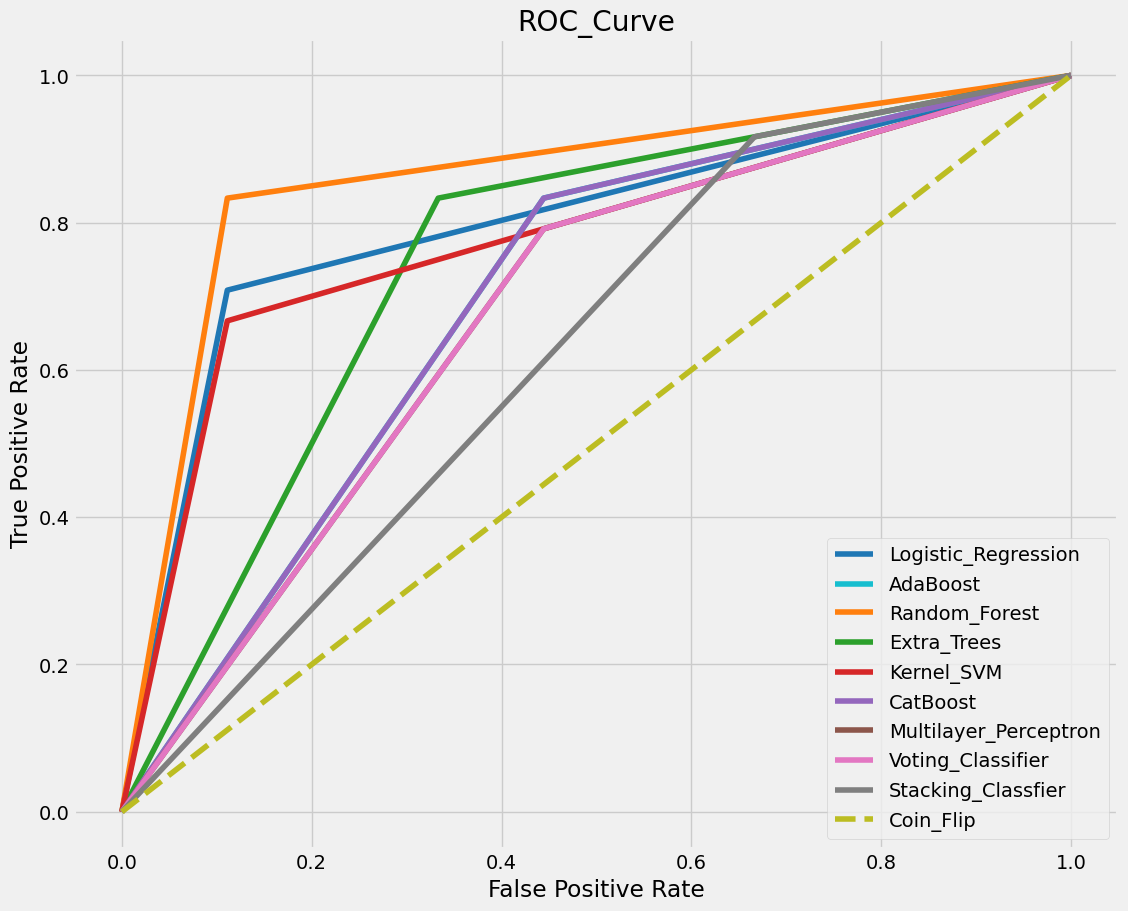

In [102]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='tab:blue', label='Logistic_Regression')
plt.plot(fpr_ABC, tpr_ABC, linestyle='-', color='tab:cyan', label='AdaBoost')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='tab:orange', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='tab:green', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='tab:red', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='tab:purple', label='CatBoost')
plt.plot(fpr_MLP, tpr_MLP, linestyle='-', color='tab:brown', label='Multilayer_Perceptron')
plt.plot(fpr_VOC, tpr_VOC, linestyle='-', color='tab:pink', label='Voting_Classifier')
plt.plot(fpr_STC, tpr_STC, linestyle='-', color='tab:grey', label='Stacking_Classfier')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='tab:olive', label="Coin_Flip")
plt.xlim([-0.05, 1.05])
plt.ylim([-.05, 1.05])
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

#### Precision Recall Curve

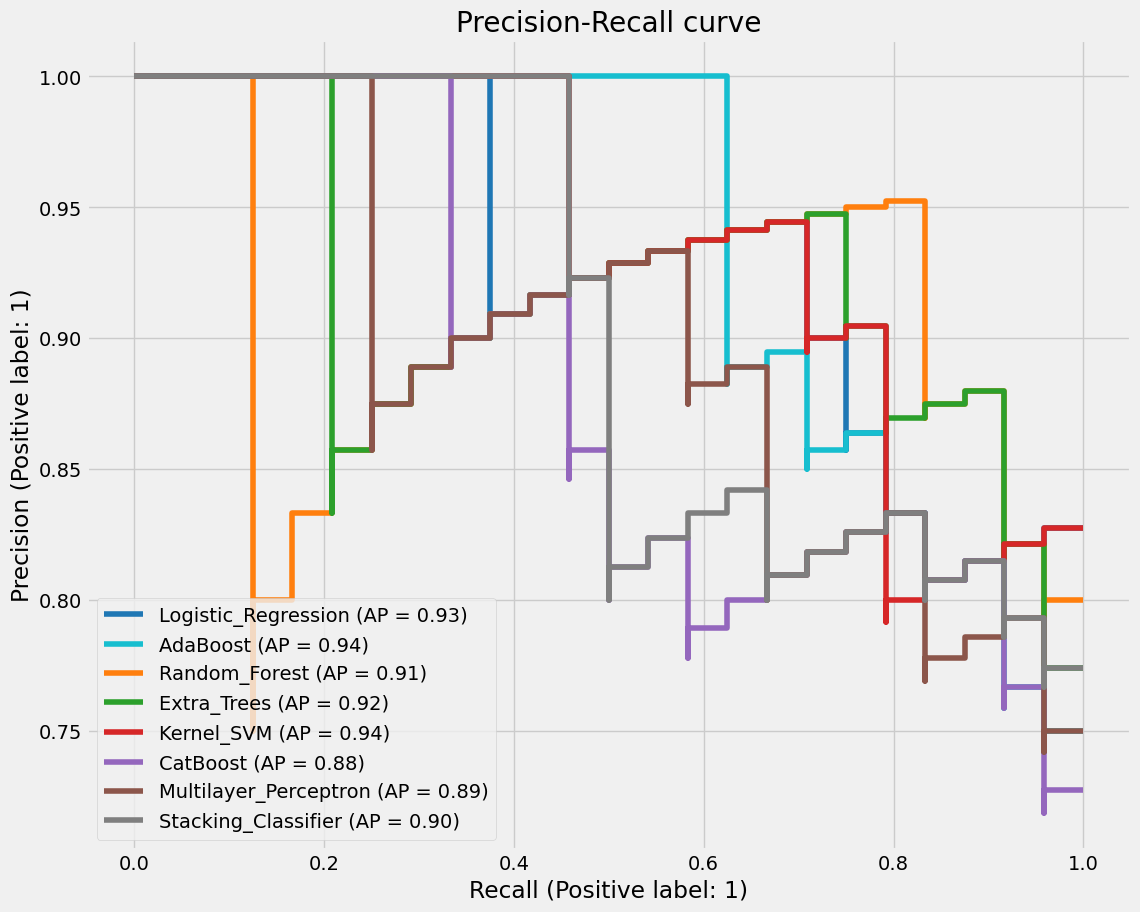

In [103]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Log_Reg, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:blue', name = "Logistic_Regression")
plot_precision_recall_curve(ABC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:cyan', name = "AdaBoost")
plot_precision_recall_curve(RFC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:orange', name = "Random_Forest")
plot_precision_recall_curve(ETC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:green', name = "Extra_Trees")
plot_precision_recall_curve(KSV, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:red', name = "Kernel_SVM")
plot_precision_recall_curve(CBC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:purple', name = "CatBoost")
plot_precision_recall_curve(MLP, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:brown', name = "Multilayer_Perceptron")
plot_precision_recall_curve(STC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:grey', name = "Stacking_Classifier")
plt.legend(loc='best')
plt.title('Precision-Recall curve')
plt.show()

#### SHAP Model Explainer

In [104]:
# Model Explainability Using SHAP - CatBoost Classifier

explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [105]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


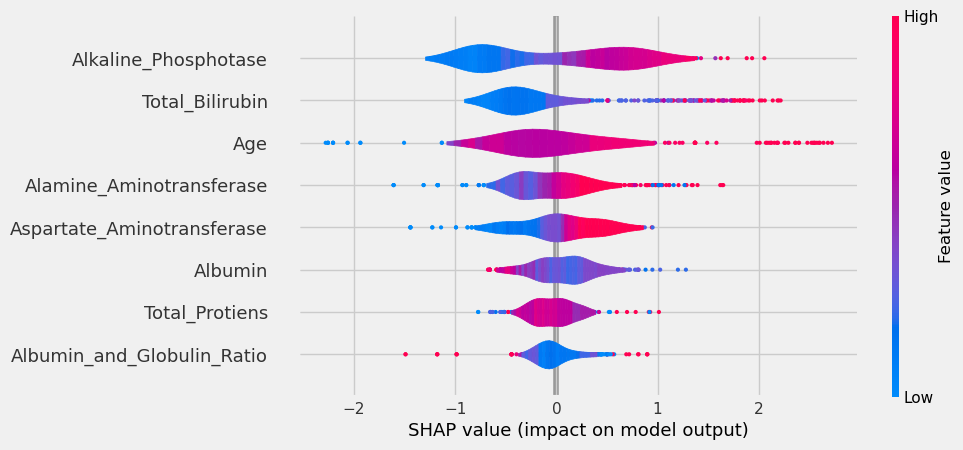

In [106]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst), title='CatBoost Model Explainer')

In [107]:
OUTFILE = r"Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='Metrics', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Report', index=True)
writer.save()

#### Notebook to HTML

In [108]:
# !jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" GS_MLM_CLF_V2.2.ipynb --to html

In [110]:
NB_Convert = u"jupyter nbconvert --to html_toc --output " # Trailing space is required.
NB_Name = u"GS_MLM_CLF_V3.0_LiverPatient.ipynb"
PREFIX_A = PREFIX[:-1]
HTML_Name = PREFIX_A.replace("\\", "") + " " # Trailing space is required.
Names_Concat = NB_Convert + HTML_Name + NB_Name
try:
    if(__IPYTHON__):
        get_ipython().system(Names_Concat)
except NameError:
    pass

[NbConvertApp] Converting notebook GS_MLM_CLF_V3.0_LiverPatient.ipynb to html_toc
[NbConvertApp] Support files will be in MLM_V3.0_LiverPatient_I1_files\
[NbConvertApp] Making directory MLM_V3.0_LiverPatient_I1_files
[NbConvertApp] Making directory MLM_V3.0_LiverPatient_I1_files
[NbConvertApp] Making directory MLM_V3.0_LiverPatient_I1_files
[NbConvertApp] Writing 704541 bytes to MLM_V3.0_LiverPatient_I1.html
